## <center> Практическое задание к лекции №6

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [4]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

автоматизация обучения

In [6]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

**1.** Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.  

---

In [7]:
from sklearn.datasets import load_diabetes

In [8]:
X, y = load_diabetes(return_X_y=True)

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.25
)

исследуем зависимость от числа деревьев

In [10]:
def get_errors(X_train, X_test, y_train, y_test, eta, n_trees):
    all_train_err={}
    all_test_err={}
    for depth in tqdm(range(1,8,2)):
        train_err=[]
        test_err=[]
        for n_tree in tqdm(n_trees):
            coefs=[1]*n_tree
            trees, train_errors, test_errors=gb_fit(n_tree, depth, X_train, X_test, y_train, y_test, coefs, eta)
            train_pred = gb_predict(X_train, trees, coefs, eta)
            train_err.append(mean_squared_error(y_train, train_pred))
            test_pred=gb_predict(X_test, trees, coefs, eta)
            test_err.append(mean_squared_error(y_test, test_pred))
    
        all_train_err[depth]=train_err
        all_test_err[depth]=test_err
    return all_train_err, all_test_err,eta,n_trees

In [11]:
def get_plot(train_err,test_err,eta,n_trees):
    fif, ax= plt.subplots(figsize = (16, 18))
    plt.subplot(2,1,1)
    for key in train_err.keys():
        
        
        plt.plot(n_trees,train_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Ошибка на тренировочной выборке в \nзависимости от глубины и числа деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
        
    plt.subplot(2,1,2)
    for key in test_err.keys():    
        plt.plot(n_trees,test_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Ошибка на тестовой выборке в \nзависимости от глубины и числа деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
    plt.show()

In [12]:

n_trees=[1, 5, 10, 30, 50, 100]
eta=0.1
tr_err, tst_err, eta, n_trees=get_errors(X_train, X_test, y_train, y_test, eta, n_trees)



100%|██████████| 4/4 [29:18<00:00, 439.58s/it]


<ipython-input-11-c8eeb3b30af1>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


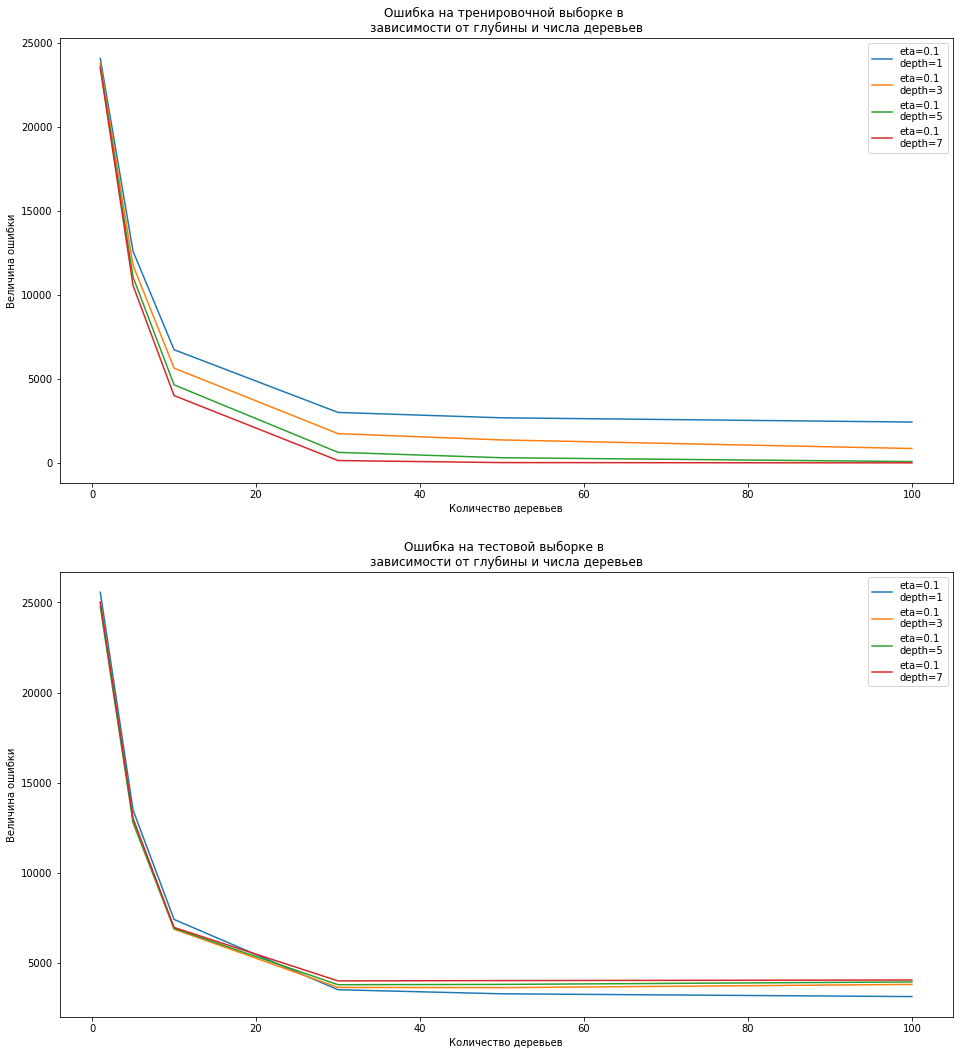

In [13]:
get_plot(tr_err, tst_err, eta, n_trees)

Из графиков видно, что при равных значениях шага обучения увеличение глубины деревьев ведет к снижению ошибки на трейне, но при этом ошибка на тесте растет, относительно менее глубоких деревьев. При этом, с увеличением числа деревьев с низкой глубиной ошибка на тесте уменьшается, в данном случае целесообразнее использовать лес из 100 пеньков. 

**2.** Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.  

---

In [14]:
def gb_sgd_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # Определяем случайные индексы
        random_idx = set()
        
        while len(random_idx) < X_train.shape[0]//2:
            random_idx.add(np.random.randint(0, X_train.shape[0]))
        random_idx=list(random_idx)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[random_idx], y_train[random_idx])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[random_idx], bias(y_train[random_idx], target[random_idx]))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [15]:
n_trees=100
max_depth=4
eta=0.1
coefs=[1]*n_trees
trees, tr_err, tst_err=gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
sgd_trees, sgd_tr_err, sgd_tst_err=gb_sgd_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [16]:
def get_error_plot(n_trees, train_err, test_err):
    plt.figure(figsize=(16,10))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='sgd_train error')
    plt.legend(loc='upper right')
    plt.show()

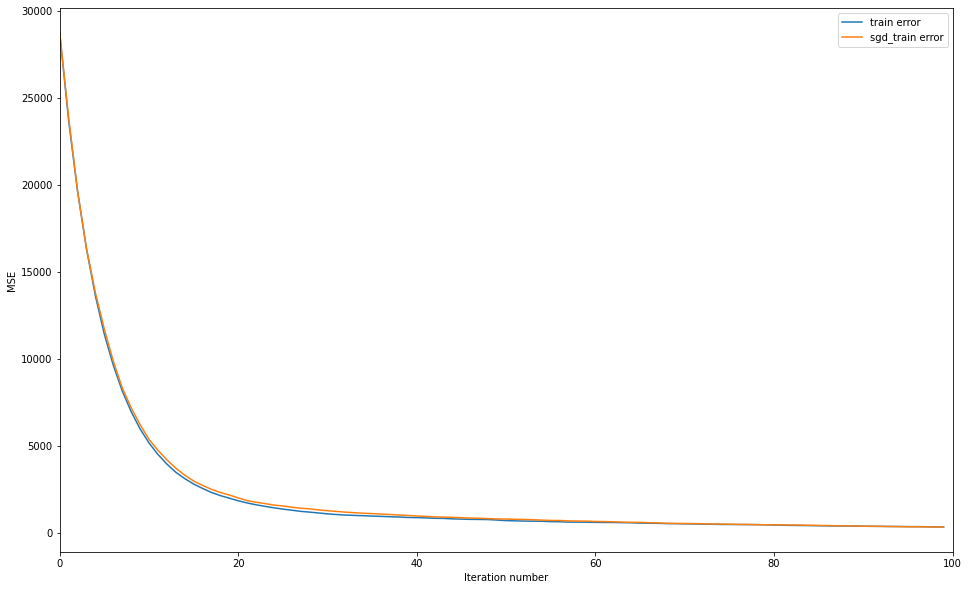

In [17]:
get_error_plot(n_trees, tr_err, sgd_tr_err)

Из графиков видно, что отличия практически нет